In [1]:
import torch
import umap
import anndata
import numpy as np
import os
import gc
import pandas as pd
import timeit
import warnings
warnings.filterwarnings('ignore')
import faiss
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import sklearn
from scipy import stats
import scanpy as sc
from numpy import linalg as LA
from sklearn.neighbors import kneighbors_graph
#from datasets import AnnDataset, NumpyDataset
import matplotlib.pyplot as plt
import anndata
from matplotlib.pyplot import figure
from multiprocessing import Process
from sklearn.cluster import KMeans
from fast_generator_cancer import *
from fast_functions_cancer import *

Global seed set to 0


scVI ready


/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
#canceradata = anndata.read_h5ad('normed_hv_cancer.h5ad')#('canceradata.h5ad')

In [3]:
bulkdata = anndata.read_h5ad('bulkcount.h5ad')
sids = bulkdata.obs['sampleid']

In [4]:
pids=sids

In [5]:
pids.shape

(112,)

In [6]:
### check cell num in samples
pids = []
c=0
samplemask = []
for i in range(len(sids)):
    sid = sids[i]
    adata = anndata.read_h5ad('sample_sc/'+sid+'.h5ad')
    if adata.X.shape[0] <1000:
        print(i)



In [7]:
bulkdata

AnnData object with n_obs × n_vars = 112 × 33287
    obs: 'sampleid'
    var: 'gene_symbols', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'

In [8]:
bulkdata.X.max()

2536.2844

In [9]:
sc.pp.log1p(bulkdata)

In [10]:
sc.tl.pca(bulkdata, svd_solver='arpack',n_comps=100)

In [11]:
bulkdata

AnnData object with n_obs × n_vars = 112 × 33287
    obs: 'sampleid'
    var: 'gene_symbols', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [12]:
BATCH_SIZE = 4
kmeans = KMeans(n_clusters=BATCH_SIZE, random_state=0).fit(bulkdata.obsm['X_pca'])
cluster_labels = kmeans.labels_

In [13]:
# select representatives
pnums = []
for i in range(len(bulkdata.X)):
    pnums.append(i)
pnums=np.array(pnums)


centers=[]
representatives=[]
repredic={}

for i in range(len(np.unique(cluster_labels))):
    mask = (cluster_labels==i)
    cluster = bulkdata.obsm['X_pca'][mask]
    cluster_patients = pnums[mask]
    center = cluster.mean(axis=0)
    centers.append(center)
            
    # find the closest patient
    sqdist = ((cluster - center)**2).sum(axis=1)

    cluster_representative = cluster_patients[np.argmin(sqdist)]
    representatives.append(cluster_representative)
    repredic[i] = cluster_representative
        
centers = np.array(centers)


In [14]:
#representatives

In [15]:
pids = sids

In [16]:
pids[representatives[1]]

'SMC10-T'

In [17]:
init_cluster_labels = cluster_labels
init_representatives = representatives

In [18]:
# umap for sample bulk
dimred=umap.UMAP(min_dist=0.3,n_neighbors=15)
vis_bulk=dimred.fit_transform(bulkdata.obsm['X_pca'])

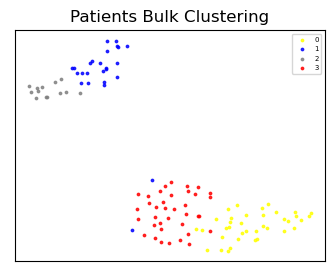

In [19]:
# sample plot
fig, ax = plt.subplots(figsize=(4,3),dpi=100)
colormap = ['yellow','blue','gray','red','green','black','darkgreen','darkorange','crimson',\
            'purple','navy','aquamarine','plum','violet','olive','steelblue']

for i in range(BATCH_SIZE):
    group = vis_bulk[np.array(cluster_labels)==i] #uz34
    ax.scatter(group[:,0],group[:,1],c=colormap[i],alpha=0.8,s=3,label=i)


plt.title('Patients Bulk Clustering')
ax.legend(fontsize=5)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

In [29]:

f=open('init_cluster_labels_4.txt','w')
for i in range(len(init_cluster_labels)):
    f.write(str(init_cluster_labels[i])+'\n')
f.close()

f=open('init_representatives_4.txt','w')
for i in range(len(init_representatives)):
    f.write(str(init_representatives[i])+'\n')
f.close()

bulkdata.write('normed_reduced_bulk.h5ad') # bad sample filtered

In [20]:
hvmask  = np.load('hvmask.npy')

In [27]:

# highly variable geneset
gsets=[]
for r in representatives:
    gsetdata = np.load('geneset/'+sids[r]+'.npy')
    gsets.append(gsetdata)
gsets = np.concatenate(gsets,axis=0)
gdata = anndata.AnnData(gsets)
sc.pp.log1p(gdata)
sc.pp.highly_variable_genes(gdata)
hvset = gdata.var.highly_variable
np.save('hvset.npy',hvset)


In [28]:
hvset.sum()

743

In [21]:

hvmask = np.load('hvmask.npy')
hvset = np.load('hvset.npy')
devices=['cuda:0','cuda:1','cuda:2','cuda:3','cuda:4','cuda:5','cuda:6','cuda:7']


In [213]:
repremodels = []

c=0
for rp in [representatives[1]]:
    device = devices[c]
    c+=1
    sid = sids[rp]
    repremodels.append(\
                       fastrecon(pid=sid,\
                      tgtpid=None,device=device,k=15,diagw=1,vaesteps=100,gansteps=100,save=True,path=None)\
                      )

INFO     Generating sequential column names                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 100/100: 100%|██████████████████████████████████████████| 100/100 [01:21<00:00,  1.17it/s, loss=1.03e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████████████████████████████████████| 100/100 [01:21<00:00,  1.22it/s, loss=1.03e+03, v_num=1]
0, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|██████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.16it/s, loss=1.03e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.15it/s, loss=1.03e+03, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|██████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.15it/s, loss=1.02e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.14it/s, loss=1.02e+03, v_num=1]
1, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|██████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s, loss=1.01e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=1.01e+03, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|██████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.13it/s, loss=1.01e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.13it/s, loss=1.01e+03, v_num=1]
2, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|██████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.16it/s, loss=1.02e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.15it/s, loss=1.02e+03, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.15it/s, loss=1e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.14it/s, loss=1e+03, v_num=1]
3, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.15it/s, loss=1e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.15it/s, loss=1e+03, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=1e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=1e+03, v_num=1]
4, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=998, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=998, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|█████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=1e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|█████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=1e+03, v_num=1]
5, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=995, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=995, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=998, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=998, v_num=1]
6, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.36it/s, loss=985, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.35it/s, loss=985, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.36it/s, loss=989, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.35it/s, loss=989, v_num=1]
7, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=995, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=995, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=990, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=990, v_num=1]
8, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=987, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=987, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=990, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=990, v_num=1]
9, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=985, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=985, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=988, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=988, v_num=1]
10, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=986, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=986, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=974, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=974, v_num=1]
11, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it, loss=966, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.24s/it, loss=966, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.21it/s, loss=970, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s, loss=970, v_num=1]
12, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s, loss=970, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s, loss=970, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.21it/s, loss=966, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s, loss=966, v_num=1]
13, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.21it/s, loss=982, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s, loss=982, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.21it/s, loss=981, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s, loss=981, v_num=1]
14, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.21it/s, loss=981, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s, loss=981, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.19it/s, loss=973, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.19it/s, loss=973, v_num=1]
15, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s, loss=975, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s, loss=975, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.19it/s, loss=984, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.19it/s, loss=984, v_num=1]
16, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=971, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.21it/s, loss=971, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=957, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=957, v_num=1]
17, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=965, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=965, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.26it/s, loss=966, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=966, v_num=1]
18, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.21it/s, loss=964, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.21it/s, loss=964, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=968, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=968, v_num=1]
19, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=963, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=963, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=960, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=960, v_num=1]
20, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=954, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=954, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s, loss=968, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s, loss=968, v_num=1]
21, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=968, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=968, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.26it/s, loss=957, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=957, v_num=1]
22, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=960, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=960, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=954, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=954, v_num=1]
23, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.26it/s, loss=947, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=947, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=953, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=953, v_num=1]
24, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=965, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=965, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=952, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=952, v_num=1]
25, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=955, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=955, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=950, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=950, v_num=1]
26, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=954, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=954, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=951, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=951, v_num=1]
27, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=948, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=948, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=952, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=952, v_num=1]
28, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=967, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=967, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=953, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=953, v_num=1]
29, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=952, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=952, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=953, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=953, v_num=1]
30, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s, loss=944, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s, loss=944, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=945, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=945, v_num=1]
31, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=939, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=939, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=943, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=943, v_num=1]
32, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=951, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=951, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=948, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=948, v_num=1]
33, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=943, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=943, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=951, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=951, v_num=1]
34, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=941, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=941, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=954, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=954, v_num=1]
35, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.21it/s, loss=935, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s, loss=935, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=959, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=959, v_num=1]
36, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=945, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=945, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=931, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.21it/s, loss=931, v_num=1]
37, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=952, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.21it/s, loss=952, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=955, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=955, v_num=1]
38, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=957, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=957, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=934, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=934, v_num=1]
39, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=931, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=931, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=962, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=962, v_num=1]
40, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=928, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=928, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.30it/s, loss=946, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.27it/s, loss=946, v_num=1]
41, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.36it/s, loss=934, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.35it/s, loss=934, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=966, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=966, v_num=1]
42, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=944, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=944, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=964, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=964, v_num=1]
43, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=935, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=935, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=955, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=955, v_num=1]
44, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=929, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=929, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=940, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=940, v_num=1]
45, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=937, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=937, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=947, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=947, v_num=1]
46, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=958, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=958, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=955, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=955, v_num=1]
47, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=932, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=932, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=943, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=943, v_num=1]
48, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=923, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=923, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=938, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=938, v_num=1]
49, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=940, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=940, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=936, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=936, v_num=1]
50, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=931, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=931, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=927, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=927, v_num=1]
51, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=935, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=935, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=929, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=929, v_num=1]
52, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=931, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=931, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=922, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=922, v_num=1]
53, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=916, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=916, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=913, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=913, v_num=1]
54, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=925, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=925, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=920, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=920, v_num=1]
55, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=927, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=927, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=918, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=918, v_num=1]
56, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=927, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=927, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.26it/s, loss=923, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=923, v_num=1]
57, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=920, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=920, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.26it/s, loss=927, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=927, v_num=1]
58, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=914, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=914, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=921, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=921, v_num=1]
59, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=928, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=928, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=924, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=924, v_num=1]
60, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=926, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=926, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=919, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=919, v_num=1]
61, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=930, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=930, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.26it/s, loss=917, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=917, v_num=1]
62, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=918, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=918, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.26it/s, loss=919, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=919, v_num=1]
63, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=930, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=930, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=922, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=922, v_num=1]
64, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.26it/s, loss=928, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=928, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.26it/s, loss=913, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=913, v_num=1]
65, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=927, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=927, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=920, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=920, v_num=1]
66, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.26it/s, loss=920, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=920, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=918, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=918, v_num=1]
67, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.26it/s, loss=923, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=923, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=921, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=921, v_num=1]
68, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=913, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=913, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.26it/s, loss=912, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=912, v_num=1]
69, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.26it/s, loss=910, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=910, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.26it/s, loss=900, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=900, v_num=1]
70, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=910, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=910, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=921, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=921, v_num=1]
71, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=914, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=914, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=929, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=929, v_num=1]
72, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=923, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=923, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=914, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=914, v_num=1]
73, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=910, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=910, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=919, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=919, v_num=1]
74, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.25it/s, loss=914, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=914, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=912, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=912, v_num=1]
75, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=918, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=918, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=912, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=912, v_num=1]
76, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=918, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=918, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=913, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=913, v_num=1]
77, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=899, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=899, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=926, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=926, v_num=1]
78, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=921, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=921, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=900, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=900, v_num=1]
79, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s, loss=908, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.19it/s, loss=908, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s, loss=902, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.19it/s, loss=902, v_num=1]
80, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s, loss=911, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.19it/s, loss=911, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.21it/s, loss=911, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s, loss=911, v_num=1]
81, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s, loss=914, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.19it/s, loss=914, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s, loss=921, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.19it/s, loss=921, v_num=1]
82, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s, loss=907, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.19it/s, loss=907, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s, loss=907, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.19it/s, loss=907, v_num=1]
83, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.19it/s, loss=910, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.18it/s, loss=910, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.19it/s, loss=908, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.19it/s, loss=908, v_num=1]
84, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.21it/s, loss=914, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s, loss=914, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.21it/s, loss=906, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s, loss=906, v_num=1]
85, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=898, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=898, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.20it/s, loss=914, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.19it/s, loss=914, v_num=1]
86, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=908, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.21it/s, loss=908, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=904, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.21it/s, loss=904, v_num=1]
87, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.19it/s, loss=903, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.18it/s, loss=903, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=908, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.21it/s, loss=908, v_num=1]
88, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=911, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=911, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=907, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=907, v_num=1]
89, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=910, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=910, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=901, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.21it/s, loss=901, v_num=1]
90, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=914, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.21it/s, loss=914, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.19it/s, loss=891, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.18it/s, loss=891, v_num=1]
91, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=909, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=909, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=896, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=896, v_num=1]
92, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=905, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.21it/s, loss=905, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=910, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=910, v_num=1]
93, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=903, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=903, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=900, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.21it/s, loss=900, v_num=1]
94, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=914, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=914, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=925, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.21it/s, loss=925, v_num=1]
95, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=907, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=907, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=904, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=904, v_num=1]
96, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=911, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=911, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=911, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=911, v_num=1]
97, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=903, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.22it/s, loss=903, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=900, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=900, v_num=1]
98, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=899, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=899, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=911, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=911, v_num=1]
99, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=901, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=901, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.24it/s, loss=912, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.23it/s, loss=912, v_num=1]


In [215]:
# check training history
model= repremodels[0]
#plt.plot( model.history['kl_global_train'])

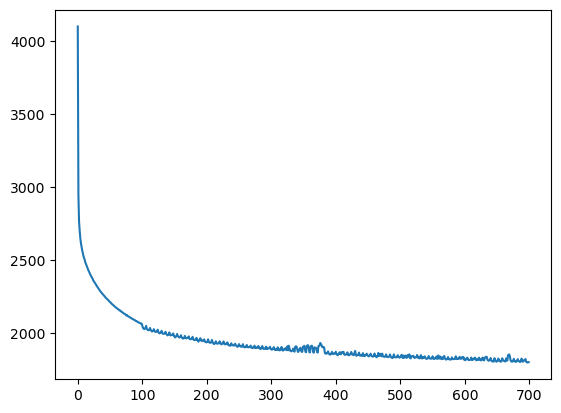

In [216]:
plt.plot( model.history['train_loss_epoch'])

In [ ]:
repremodels2=[]
i=0
for rp in [representatives[1]]:
    i=i%8
    device = devices[i]
    sid = sids[rp]
    repremodels2.append(reconst_pretrain2(sid,repremodels[i],device,k=15,diagw=1.0,vaesteps=50,gansteps=50,save=True))
    i+=1

INFO     Generating sequential column names                                                  
INFO     Generating sequential column names                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 50/50: 100%|███████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.58it/s, loss=751, v_num=1]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|███████████████████████████████████████████████████| 50/50 [00:19<00:00,  2.58it/s, loss=751, v_num=1]
0, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.57it/s, loss=736, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.54it/s, loss=736, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.55it/s, loss=709, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.52it/s, loss=709, v_num=1]
1, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.54it/s, loss=708, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s, loss=708, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.54it/s, loss=706, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.51it/s, loss=706, v_num=1]
2, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.54it/s, loss=706, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.51it/s, loss=706, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.54it/s, loss=705, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s, loss=705, v_num=1]
3, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.52it/s, loss=705, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s, loss=705, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s, loss=702, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s, loss=702, v_num=1]
4, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.53it/s, loss=700, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s, loss=700, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.53it/s, loss=704, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s, loss=704, v_num=1]
5, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.53it/s, loss=703, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s, loss=703, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.56it/s, loss=696, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.53it/s, loss=696, v_num=1]
6, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.57it/s, loss=697, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.53it/s, loss=697, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.54it/s, loss=697, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s, loss=697, v_num=1]
7, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.56it/s, loss=713, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.52it/s, loss=713, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.55it/s, loss=700, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.51it/s, loss=700, v_num=1]
8, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.55it/s, loss=700, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.52it/s, loss=700, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.55it/s, loss=693, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.52it/s, loss=693, v_num=1]
9, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.57it/s, loss=702, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.54it/s, loss=702, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.57it/s, loss=690, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.53it/s, loss=690, v_num=1]
10, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.81it/s, loss=701, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.77it/s, loss=701, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s, loss=699, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s, loss=699, v_num=1]
11, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s, loss=697, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s, loss=697, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s, loss=699, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s, loss=699, v_num=1]
12, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s, loss=695, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s, loss=695, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s, loss=700, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s, loss=700, v_num=1]
13, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s, loss=696, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s, loss=696, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s, loss=701, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s, loss=701, v_num=1]
14, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s, loss=697, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s, loss=697, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s, loss=705, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s, loss=705, v_num=1]
15, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s, loss=690, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s, loss=690, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s, loss=692, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s, loss=692, v_num=1]
16, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s, loss=702, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s, loss=702, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s, loss=692, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s, loss=692, v_num=1]
17, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s, loss=693, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s, loss=693, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s, loss=702, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s, loss=702, v_num=1]
18, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s, loss=699, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s, loss=699, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s, loss=705, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s, loss=705, v_num=1]
19, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s, loss=695, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s, loss=695, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s, loss=696, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s, loss=696, v_num=1]
20, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s, loss=698, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s, loss=698, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s, loss=694, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.42it/s, loss=694, v_num=1]
21, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s, loss=695, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s, loss=695, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s, loss=693, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s, loss=693, v_num=1]
22, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s, loss=700, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s, loss=700, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s, loss=694, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s, loss=694, v_num=1]
23, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s, loss=704, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s, loss=704, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s, loss=699, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s, loss=699, v_num=1]
24, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s, loss=697, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s, loss=697, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s, loss=703, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s, loss=703, v_num=1]
25, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s, loss=695, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s, loss=695, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s, loss=693, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s, loss=693, v_num=1]
26, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.53it/s, loss=699, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s, loss=699, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s, loss=687, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s, loss=687, v_num=1]
27, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.51it/s, loss=694, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s, loss=694, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s, loss=694, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s, loss=694, v_num=1]
28, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s, loss=690, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s, loss=690, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s, loss=696, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s, loss=696, v_num=1]
29, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s, loss=693, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s, loss=693, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s, loss=704, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s, loss=704, v_num=1]
30, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.51it/s, loss=696, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s, loss=696, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s, loss=688, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s, loss=688, v_num=1]
31, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s, loss=700, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s, loss=700, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s, loss=700, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s, loss=700, v_num=1]
32, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s, loss=693, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s, loss=693, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.51it/s, loss=688, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s, loss=688, v_num=1]
33, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s, loss=690, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s, loss=690, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s, loss=697, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s, loss=697, v_num=1]
34, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s, loss=695, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s, loss=695, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.51it/s, loss=695, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s, loss=695, v_num=1]
35, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.51it/s, loss=693, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s, loss=693, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s, loss=697, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s, loss=697, v_num=1]
36, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s, loss=689, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s, loss=689, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s, loss=697, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s, loss=697, v_num=1]
37, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.51it/s, loss=697, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s, loss=697, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.52it/s, loss=701, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s, loss=701, v_num=1]
38, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s, loss=694, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s, loss=694, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s, loss=693, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s, loss=693, v_num=1]
39, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.52it/s, loss=696, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s, loss=696, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.52it/s, loss=695, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s, loss=695, v_num=1]
40, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.53it/s, loss=690, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s, loss=690, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s, loss=694, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s, loss=694, v_num=1]
41, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s, loss=700, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s, loss=700, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.51it/s, loss=695, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s, loss=695, v_num=1]
42, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s, loss=697, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s, loss=697, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.53it/s, loss=696, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s, loss=696, v_num=1]
43, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.52it/s, loss=699, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s, loss=699, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s, loss=688, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s, loss=688, v_num=1]
44, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.51it/s, loss=696, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s, loss=696, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.54it/s, loss=692, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.51it/s, loss=692, v_num=1]
45, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.53it/s, loss=692, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s, loss=692, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s, loss=689, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s, loss=689, v_num=1]
46, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.52it/s, loss=692, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s, loss=692, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.53it/s, loss=690, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.49it/s, loss=690, v_num=1]
47, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.53it/s, loss=688, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.50it/s, loss=688, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.48it/s, loss=698, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s, loss=698, v_num=1]
48, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s, loss=690, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s, loss=690, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s, loss=696, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s, loss=696, v_num=1]
49, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.46it/s, loss=690, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.42it/s, loss=690, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.47it/s, loss=692, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.43it/s, loss=692, v_num=1]
INFO     Generating sequential column names                                                  
INFO     Generating sequential column names                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 50/50: 100%|███████████████████████████████████████████████████| 50/50 [00:45<00:00,  1.11it/s, loss=903, v_num=1]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 50/50: 100%|███████████████████████████████████████████████████| 50/50 [00:45<00:00,  1.11it/s, loss=903, v_num=1]
0, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=884, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=884, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=895, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=895, v_num=1]
1, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=890, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.08it/s, loss=890, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=896, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=896, v_num=1]
2, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=899, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=899, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=894, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.08it/s, loss=894, v_num=1]
3, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=883, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=883, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=903, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=903, v_num=1]
4, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=890, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=890, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=892, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=892, v_num=1]
5, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=904, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=904, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=887, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=887, v_num=1]
6, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=887, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=887, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=918, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=918, v_num=1]
7, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=903, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=903, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=890, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=890, v_num=1]
8, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=898, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=898, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=891, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=891, v_num=1]
9, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=888, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=888, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=903, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=903, v_num=1]
10, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=897, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=897, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=895, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=895, v_num=1]
11, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=896, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=896, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=883, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=883, v_num=1]
12, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=899, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=899, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s, loss=891, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=891, v_num=1]
13, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=895, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=895, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=904, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=904, v_num=1]
14, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=896, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=896, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=894, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=894, v_num=1]
15, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s, loss=898, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=898, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=887, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.08it/s, loss=887, v_num=1]
16, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=885, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=885, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=883, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.08it/s, loss=883, v_num=1]
17, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=894, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=894, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=900, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=900, v_num=1]
18, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=900, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=900, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=906, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=906, v_num=1]
19, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=880, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=880, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=892, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=892, v_num=1]
20, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=882, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=882, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=902, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=902, v_num=1]
21, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=901, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=901, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=896, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=896, v_num=1]
22, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=883, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=883, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=898, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=898, v_num=1]
23, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=892, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.08it/s, loss=892, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=887, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=887, v_num=1]
24, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=892, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=892, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=887, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=887, v_num=1]
25, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=912, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=912, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=887, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=887, v_num=1]
26, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=889, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=889, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=897, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=897, v_num=1]
27, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=888, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=888, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=889, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=889, v_num=1]
28, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.13it/s, loss=897, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s, loss=897, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.13it/s, loss=888, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s, loss=888, v_num=1]
29, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s, loss=902, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s, loss=902, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s, loss=882, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s, loss=882, v_num=1]
30, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s, loss=888, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s, loss=888, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s, loss=891, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=891, v_num=1]
31, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s, loss=904, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=904, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s, loss=887, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=887, v_num=1]
32, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s, loss=896, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=896, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s, loss=892, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=892, v_num=1]
33, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s, loss=890, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=890, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s, loss=892, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.12it/s, loss=892, v_num=1]
34, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=895, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=895, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=886, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.08it/s, loss=886, v_num=1]
35, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=888, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=888, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=887, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=887, v_num=1]
36, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=878, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=878, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=884, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=884, v_num=1]
37, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=888, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=888, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=890, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=890, v_num=1]
38, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=895, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=895, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=902, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=902, v_num=1]
39, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=891, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=891, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=882, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=882, v_num=1]
40, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=895, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=895, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=883, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=883, v_num=1]
41, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=890, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=890, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=889, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=889, v_num=1]
42, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=896, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=896, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=890, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=890, v_num=1]
43, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=884, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=884, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=893, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=893, v_num=1]
44, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=891, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=891, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=886, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=886, v_num=1]
45, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=895, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=895, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=902, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.09it/s, loss=902, v_num=1]
46, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=889, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=889, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.11it/s, loss=888, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=888, v_num=1]
47, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=897, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=897, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=885, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=885, v_num=1]
48, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=891, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=891, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=886, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|███████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.10it/s, loss=886, v_num=1]
49, 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


NameError: name 'repremodels2' is not defined

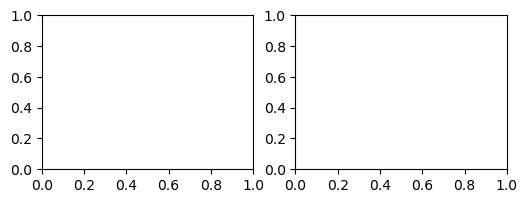

In [184]:
# check training 
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(6, 2))
ax1.plot(repremodels2[1].history['train_loss_epoch'])
ax2.plot(repremodels2[1].history['kl_global_train'])

In [23]:
device = 'cuda:0'

In [24]:
representatives

[37, 95, 87, 57]

In [25]:
reconpid = sids[representatives[3]]
adata,adj,variances,bulk,geneset_len = setdata(reconpid,None,device=device,k=15,diagw=1.0)

reconmodel = fastgenerator(adj = adj,variances = variances,markermask = None,bulk=bulk,geneset_len = geneset_len,adata=adata,\
                n_hidden=256,n_latent=32,dropout_rate=0,countbulkweight=0,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,\
                power=2,corrbulkweight=0,meanbias=0)
reconmodel.module.load_state_dict(torch.load('cancer_models/fastreconst2_'+str(reconpid)))
reconmodel.module.eval()


INFO     Generating sequential column names                                                  


myVAE(
  (z_encoder): myEncoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=4053, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): ReLU()
          (4): None
        )
      )
    )
    (g_encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=743, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): ReLU()
          (4): None
        )
        (Layer 1): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): ReLU()
          (4): None
        )
      )
    )
    (mean_encoder): 

In [26]:
adata.X.sum(axis=1)

array([2689.2817, 3107.601 , 2774.2183, ..., 3092.4963, 2728.771 ,
       2685.905 ], dtype=float32)

In [27]:
adata

AnnData object with n_obs × n_vars = 2010 × 4796
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'sample.ID', 'patient.ID', 'sample.origin', 'dataset', 'cell.type', 'cellidx', 'selfw', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'neighbors', 'neighborx'

In [28]:
x=adata.X
(x!=0).sum(axis=1)

array([141, 132, 117, ..., 157, 196, 207])

In [75]:
'''Setting up reconstruction model'''

#repnum = 4
#adata = anndata.read_h5ad('COVID_HV_GT/'+pids[representatives[repnum]]+'.h5ad')
#adata = repremodels2[repnum].adata
#reconmodel = repremodels2[0]
reconmodel._validate_anndata(adata)
fastgenerator.setup_anndata(adata)


scdl = reconmodel._make_data_loader(
        adata=adata,batch_size = adata.X.shape[0]
)



x_r = []
for tensors in scdl:
    samples = reconmodel.module.sample(tensors, n_samples=1,bound=0)
    x_r.append(np.array(samples))
    
x_r = np.concatenate(x_r) 
x_r = x_r[:,:hvmask.sum()]


INFO     Generating sequential column names                                                  


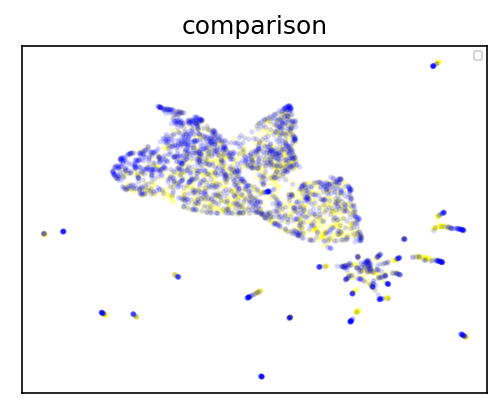

In [76]:
# repre umap
from sklearn.decomposition import PCA
xr = x_r*(x_r>1)
xm = np.concatenate([xr[:,:hvmask.sum()],adata.X[:,:hvmask.sum()]],axis=0)
n_dim = 100

#xm=xm*(xm>10)

xmdata=AnnData(xm)
#sc.pp.normalize_total(xmdata,1e4)
#sc.pp.log1p(xmdata)
xm=xmdata.X

pca = PCA(n_components=40)
#pca.fit(xm)
xmpca = pca.fit_transform(xm)

dimred=umap.UMAP(min_dist=0.3,n_neighbors=15)
xm2d=dimred.fit_transform(xmpca)

fig, ax = plt.subplots(figsize=(4,3),dpi=150)

celltypes = np.unique(adata.obs['cell.type'])

colors=[]
for i in range(len(x_r)):
    colors.append('yellow')
for i in range(len(adata.X)):
    colors.append('blue')

ax.scatter(xm2d[:,0],xm2d[:,1],c=colors,alpha=0.1,s=3)
    
plt.title('comparison')
ax.legend(fontsize=5)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

In [77]:
representatives 

[37, 95, 87, 57]

### Semi-profiling

In [14]:

gts=[]
for i in range(len(sids)):
    sid = sids[i]
    adata = anndata.read_h5ad('sample_sc/' + sid + '.h5ad')
    gt = np.array(adata[:,hvmask].X.todense())
    gts.append(gt)
    print(i,end=', ')
    
del adata

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 

In [97]:
pp=8

dis = 1 #0.2

def unisemi0(adata,adj,variances,geneset_len,bulk,batch_size,reprepid,tgtpid,premodel,device='cuda:5',k=15,diagw=1.0):
    model0 = fastgenerator(adata=adata,adj=adj,variances=variances,geneset_len=geneset_len,\
                      markermask=None,bulk=bulk,n_hidden=256,n_latent=32,\
                     dropout_rate=0,countbulkweight =1*pp,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,corrbulkweight=0,\
                      power=2,upperbound=99999,meanbias=0)
    if type(premodel)==type('string'):
        model0.module.load_state_dict(torch.load(premodel))
    else:
        model0.module.load_state_dict(premodel.module.state_dict())
    lr = adata.X.shape[0] / (4e3) * 2e-4
    lr = 2e-4 * dis
    model0.train(max_epochs=400, plan_kwargs={'lr':lr,'lr2':1e-10,'kappa':4040*1e-10},use_gpu=device,batch_size=batch_size)
    torch.save(model0.module.state_dict(), 'tmp/model0')
    return model0.history


def unisemi1(adata,adj,variances,geneset_len,bulk,batch_size,upperbound,reprepid,tgtpid,premodel,device='cuda:5',k=15,diagw=1.0):
    model1 = fastgenerator(adata=adata,adj=adj,variances=variances,geneset_len=geneset_len,\
                      markermask=None,bulk=bulk,n_hidden=256,n_latent=32,\
                     dropout_rate=0,countbulkweight = 4*pp,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,corrbulkweight=0,\
                     power=2,upperbound=upperbound,meanbias=0)
    model1.module.load_state_dict(torch.load('tmp/model0'))
    lr = adata.X.shape[0] / (4e3) * 2e-4
    lr = 2e-4 * dis
    model1.train(max_epochs=400, plan_kwargs={'lr':lr,'lr2':1e-10,'kappa':4040*1e-10},use_gpu=device,batch_size=batch_size)
    torch.save(model1.module.state_dict(), 'tmp/model1')
    return model1.history

def unisemi2(adata,adj,variances,geneset_len,bulk,batch_size,upperbound,reprepid,tgtpid,premodel,device='cuda:5',k=15,diagw=1.0):
    model2 = fastgenerator(adata=adata,adj=adj,variances=variances,geneset_len=geneset_len,\
                      markermask=None,bulk=bulk,n_hidden=256,n_latent=32,\
                     dropout_rate=0,countbulkweight = 16*pp,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,corrbulkweight=0,\
                     power=2,upperbound=upperbound,meanbias=0)
    model2.module.load_state_dict(torch.load('tmp/model1'))
    lr = adata.X.shape[0] / (4e3) * 2e-4
    lr = 2e-4 * dis
    model2.train(max_epochs=200, plan_kwargs={'lr':lr,'lr2':1e-10,'kappa':4040*1e-10},use_gpu=device,batch_size=batch_size)
    torch.save(model2.module.state_dict(), 'tmp/model2')
    return model2.history

def unisemi3(adata,adj,variances,geneset_len,bulk,batch_size,upperbound,reprepid,tgtpid,premodel,device='cuda:5',k=15,diagw=1.0):
    model3 = fastgenerator(adata=adata,adj=adj,variances=variances,geneset_len=geneset_len,\
                      markermask=None,bulk=bulk,n_hidden=256,n_latent=32,\
                     dropout_rate=0,countbulkweight = 64*pp,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,corrbulkweight=0,\
                     power=2,upperbound=upperbound,meanbias=0)
    model3.module.load_state_dict(torch.load('tmp/model2'))
    lr = adata.X.shape[0] / (4e3) * 2e-4
    lr = 2e-4 * dis
    model3.train(max_epochs=200, plan_kwargs={'lr':lr,'lr2':1e-10,'kappa':4040*1e-10},use_gpu=device,batch_size=batch_size)
    torch.save(model3.module.state_dict(), 'tmp/model3')
    return model3.history

def unisemi4(adata,adj,variances,geneset_len,bulk,batch_size,upperbound,reprepid,tgtpid,premodel,device='cuda:5',k=15,diagw=1.0):
    model4 = fastgenerator(adata=adata,adj=adj,variances=variances,geneset_len=geneset_len,\
                      markermask=None,bulk=bulk,n_hidden=256,n_latent=32,\
                     dropout_rate=0,countbulkweight = 128*pp,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,corrbulkweight=0,\
                     power=2,upperbound=upperbound,meanbias=0)
    model4.module.load_state_dict(torch.load('tmp/model3'))
    lr = adata.X.shape[0] / (4e3) * 2e-4
    lr = 2e-4 * dis
    model4.train(max_epochs=400, plan_kwargs={'lr':lr,'lr2':1e-10,'kappa':4040*1e-10},use_gpu=device,batch_size=batch_size)
    torch.save(model4.module.state_dict(), 'tmp/model4')
    return model4.history

def unisemi5(adata,adj,variances,geneset_len,bulk,batch_size,upperbound,reprepid,tgtpid,premodel,device='cuda:5',k=15,diagw=1.0):
    model = fastgenerator(adata=adata,adj=adj,variances=variances,geneset_len=geneset_len,\
                      markermask=None,bulk=bulk,n_hidden=256,n_latent=32,\
                     dropout_rate=0,countbulkweight = 512*pp,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,corrbulkweight=0,\
                     power=2,upperbound=upperbound,meanbias=0)
    model.module.load_state_dict(torch.load('tmp/model4'))
    lr = adata.X.shape[0] / (4e3) * 4e-4
    lr = 2e-4 * dis
    model.train(max_epochs=200, plan_kwargs={'lr':lr,'lr2':1e-10,'kappa':4040*1e-10},use_gpu=device,batch_size=batch_size)
    torch.save(model.module.state_dict(), 'tmp/model')
    return model.history

def fast_semi(reprepid,tgtpid,premodel,device='cuda:1',k=15,diagw=1.0):
    adata,adj,variances,bulk,geneset_len = setdata(reprepid,tgtpid,device,k,diagw)
    #adata.X = (adata.X.todense())
    
    varainces = None
    
    maxexpr = adata.X[:,:6040].max()
    upperbounds = [maxexpr/2, maxexpr/4, maxexpr/8, maxexpr/(8*np.sqrt(2)),maxexpr/16, maxexpr/32,maxexpr/64]     
       
    hvmask = np.load('hvmask.npy')
    #(5) tgt bulk
    #tgtdata = anndata.read_h5ad('COVID_HV_GT/'+tgtpid+'.h5ad')
    tgtdata = anndata.read_h5ad('sample_sc/'+tgtpid+'.h5ad')
    tgtdata.X = tgtdata.X.todense()

    
    tgtbulk = np.array(tgtdata.X)[:,hvmask]
    tgtbulk = tgtbulk.mean(axis=0)
    tgtbulk = np.array(tgtbulk).reshape((1,-1))
    bulk = adata.X.mean(axis=0)
    bulk = np.array(bulk).reshape((1,-1))
    bulk[:,:tgtbulk.shape[1]] = tgtbulk
    bulk = torch.tensor(bulk).to(device)
    
    batch_size=np.min([adata.X.shape[0],4000])
    
    
    #(6) semiprofiling
    fastgenerator.setup_anndata(adata)

    
    hist = unisemi0(adata,adj,variances,geneset_len,bulk,batch_size,reprepid,tgtpid,premodel,device=device,k=k,diagw=1.0)
    histdic={}
    histdic['total0'] = hist['train_loss_epoch']
    histdic['bulk0'] = hist['kl_global_train']
    #del premodel
    gc.collect()
    torch.cuda.empty_cache() 
    #import time
    #time.sleep(10)
    hist = unisemi1(adata,adj,variances,geneset_len,bulk,batch_size,upperbounds[0],reprepid,tgtpid,premodel,device=device,k=k,diagw=1.0)

    histdic['total1'] = hist['train_loss_epoch']
    histdic['bulk1'] = hist['kl_global_train']
    #del model0
    gc.collect()
    torch.cuda.empty_cache() 
    hist = unisemi2(adata,adj,variances,geneset_len,bulk,batch_size,upperbounds[1],reprepid,tgtpid,premodel,device=device,k=k,diagw=1.0)

    histdic['total2'] = hist['train_loss_epoch']
    histdic['bulk2'] = hist['kl_global_train']
    #del model1
    gc.collect()

    #time.sleep(10)
    torch.cuda.empty_cache() 
    
    hist = unisemi3(adata,adj,variances,geneset_len,bulk,batch_size,upperbounds[2],reprepid,tgtpid,premodel,device=device,k=k,diagw=1.0)

    histdic['total3'] = hist['train_loss_epoch']
    histdic['bulk3'] = hist['kl_global_train']
    
    
    #del model2
    gc.collect()
    torch.cuda.empty_cache() 
    #time.sleep(10)
    hist = unisemi4(adata,adj,variances,geneset_len,bulk,batch_size,upperbounds[3],reprepid,tgtpid,premodel,device=device,k=k,diagw=1.0)

    histdic['total4'] = hist['train_loss_epoch']
    histdic['bulk4'] = hist['kl_global_train']
    
    #del model3
    gc.collect()
    torch.cuda.empty_cache() 
    #time.sleep(10)
    #hist = unisemi5(adata,adj,variances,geneset_len,bulk,batch_size,upperbounds[4],reprepid,tgtpid,premodel,device=device,k=15,diagw=1.0)
    #histdic['total'] = hist['train_loss_epoch']
    #histdic['bulk'] = hist['kl_global_train']


    model = fastgenerator(adata=adata,adj=adj,variances=variances,geneset_len=geneset_len,\
                     markermask=None,bulk=bulk,n_hidden=256,n_latent=32,\
                     dropout_rate=0,countbulkweight = 512,logbulkweight=0,absbulkweight=0,abslogbulkweight=0,corrbulkweight=0,\
                     power=2,upperbound=upperbounds[3],meanbias=0)
    model.module.load_state_dict(torch.load('tmp/model4'))

    # reconstruction
    xsemi = []
    scdl = model._make_data_loader(
            adata=adata,batch_size=batch_size
    )

    for tensors in scdl:
        samples = model.module.sample(tensors, n_samples=1)
        #samples = modelf.module.nb_sample(tensors, n_samples=1)
        xsemi.append(samples)
    #xsemi = np.array(torch.cat(xsemi))[:,:6040]
    
    #torch.save(model.module.state_dict(), 'cancer_models/semi_'+reprepid+"_to_"+tgtpid)
    
    
    
    gc.collect()
    torch.cuda.empty_cache() 
    return histdic,xsemi,model

In [98]:
#reprefile = 'training_rec/init_representatives_4.txt' 
#clusterfile = 'training_rec/init_cluster_labels_4.txt' 
reprefile = 'training_rec/eer_representatives_2.txt' 
clusterfile = 'training_rec/eer_cluster_labels_2.txt' 



f= open(reprefile,'r')
lines=f.readlines()
representatives=[]
for l in lines:
    representatives.append(int(l.strip().split()[0]))
f.close()

f= open(clusterfile,'r')
cluster_labels=[]
lines=f.readlines()
for l in lines:
    cluster_labels.append(int(l.strip().split()[0]))
f.close()

In [99]:
pid=24
if pid not in representatives:
    
    device = devices[pid%8]
    tgtpid = pids[pid]
    cluster = cluster_labels[pid]
    repre_num = representatives[cluster]
    reprepid = pids[repre_num]
    premodel = 'cancer_models/fastreconst2_'+reprepid
    hists,xsemi,model = fast_semi(reprepid,tgtpid,premodel,device=device,k=15,diagw=1.0)
    
    #xsemi = np.load('semidata/fast'+reprepid+'_to_'+tgtpid+'.npy')

INFO     Generating sequential column names                                                  
INFO     Generating sequential column names                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 400/400: 100%|███████████████████████████████████████████████| 400/400 [02:49<00:00,  2.33it/s, loss=266, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████████████████████████████████████████████| 400/400 [02:49<00:00,  2.35it/s, loss=266, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 400/400: 100%|███████████████████████████████████████████████| 400/400 [02:56<00:00,  2.01it/s, loss=278, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████████████████████████████████████████████| 400/400 [02:56<00:00,  2.27it/s, loss=278, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 200/200: 100%|███████████████████████████████████████████████| 200/200 [01:29<00:00,  2.41it/s, loss=306, v_num=1]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|███████████████████████████████████████████████| 200/200 [01:29<00:00,  2.24it/s, loss=306, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 200/200: 100%|███████████████████████████████████████████████| 200/200 [01:35<00:00,  2.83it/s, loss=386, v_num=1]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|███████████████████████████████████████████████| 200/200 [01:35<00:00,  2.09it/s, loss=386, v_num=1]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Epoch 400/400: 100%|███████████████████████████████████████████████| 400/400 [02:36<00:00,  2.54it/s, loss=478, v_num=1]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████████████████████████████████████████████| 400/400 [02:36<00:00,  2.55it/s, loss=478, v_num=1]


In [100]:
histdic=hists

In [101]:
histdic.keys()

dict_keys(['total0', 'bulk0', 'total1', 'bulk1', 'total2', 'bulk2', 'total3', 'bulk3', 'total4', 'bulk4'])

In [102]:
xsemi = xsemi[0]

In [103]:
xsemi = xsemi[:,:4053]

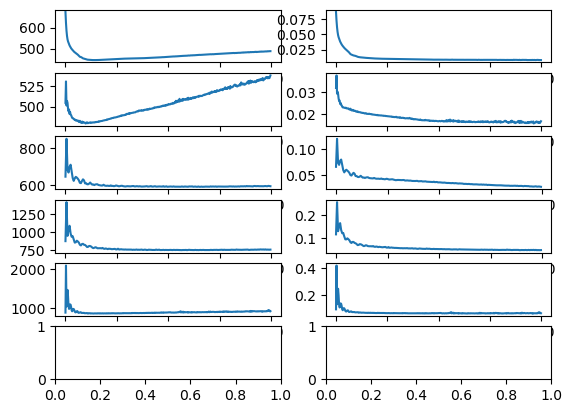

In [104]:
fig, axs = plt.subplots(6,2)
axs[0][0].plot(histdic['total0'])
axs[0][1].plot(histdic['bulk0'])
axs[1][0].plot(histdic['total1'])
axs[1][1].plot(histdic['bulk1'])
axs[2][0].plot(histdic['total2'])
axs[2][1].plot(histdic['bulk2'])
axs[3][0].plot(histdic['total3'])
axs[3][1].plot(histdic['bulk3'])
axs[4][0].plot(histdic['total4'])
axs[4][1].plot(histdic['bulk4'])

In [105]:
from sklearn.decomposition import PCA


xgt = gts[pid]
xrep = gts[representatives[cluster_labels[pid]]]
xs = xsemi * (xsemi>10)
xm = np.concatenate([xrep,xgt,xs],axis=0)
#xm = xm * (xm>20)
xm = np.log1p(xm)

pcatool =  PCA(n_components=100)
xm=pcatool.fit_transform(xm)




#umap_reduc=umap.UMAP(min_dist=0.5,spread=1.0,negative_sample_rate=5 )
umap_reduc=umap.UMAP()
xm = umap_reduc.fit_transform(xm)




colors = []
for i in range(len(xrep)):
    colors.append('blue')
    
for i in range(len(xgt)):
    colors.append('yellow')
    
for i in range(len(xsemi)):
    colors.append('red')


In [106]:
ls = xsemi.shape[0]

In [107]:
xrep.shape

(3693, 4053)

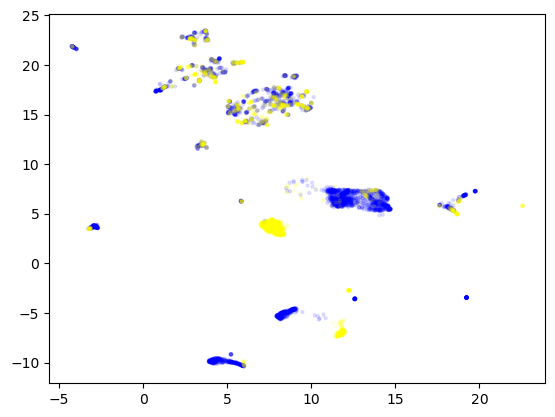

In [108]:
plt.scatter(x = xm[:-ls,0], y = xm[:-ls,1],c = colors[:-ls],s=5,alpha=0.1)

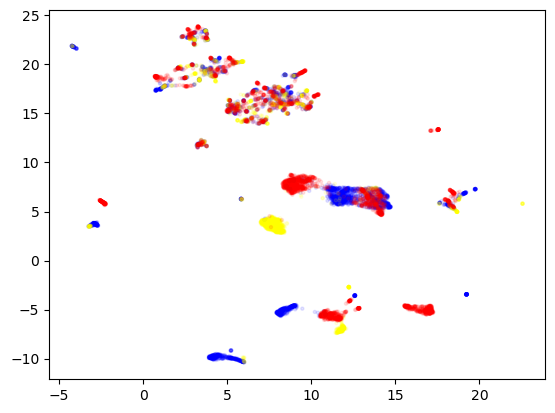

In [109]:
plt.scatter(x = xm[:,0], y = xm[:,1],c = colors[:],s=5,alpha=0.1)

In [110]:
maxlen = 0
for i in gts:
    if i.shape[0] > maxlen:
        maxlen = i.shape[0]
print(maxlen)

4397


In [98]:
np.save('semidata/fast'+reprepid+'_to_'+tgtpid+'.npy',xsemi)

In [ ]:
rnd = 0
for i in range(60,len(sids)):
    device = devices[i%8]
    repnum = cluster_labels[i]
    rep = representatives[repnum]
    print('start semiprofiling patient',str(i),'using',device,'and rep',str(rep))
    os.system('/mnt/data/jingtao2/anaconda3/envs/deep/bin/python semicommand.py '+str(i)+' '+str(device) + ' '+str(rnd))

start semiprofiling patient 60 using cuda:4 and rep 69


Global seed set to 0
/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/mnt/data/jingtao2/anaconda3/envs/deep/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [99]:
'semidata/fast'+reprepid+'_to_'+tgtpid+'.npy'

'semidata/fastMUX8725_to_MUX8815.npy'

In [ ]:
### evaluation functions

def faiss_knn(query, x, n_neighbors=1):
    n_samples = x.shape[0]
    n_features = x.shape[1]
    x = np.ascontiguousarray(x)
    
    index = faiss.IndexFlatL2(n_features)
    #index = faiss.IndexFlatIP(n_features)
                  
    index.add(x)
    
    if n_neighbors < 2:
        neighbors = 2
    else: 
        neighbors = n_neighbors
    
    weights, targets = index.search(query, neighbors)

    #sources = np.repeat(np.arange(n_samples), neighbors)
    #targets = targets.flatten()
    #weights = weights.flatten()
    weights = weights[:,:n_neighbors]
    if -1 in targets:
        raise InternalError("Not enough neighbors were found. Please consider "
                            "reducing the number of neighbors.")
    return weights

def pearson_compare(query,x):
    return 0

def cos_compare(query,x):
    return 0


def pca_compare(query,x):
    qx = np.concatenate([query,x],axis=0)
    qxpca = PCA(n_components=100)
    dx=qxpca.fit_transform(qx)
    
    newq = dx[:query.shape[0],:].copy(order='C')
    newx = dx[query.shape[0]:,:].copy(order='C')
    score = faiss_knn(newq,newx,n_neighbors=1)
    return score

def umap_compare(query,x):
    qx = np.concatenate([query,x],axis=0)
    qxpca = PCA(n_components=100)
    dpca=qxpca.fit_transform(qx)
    umap_reduc=umap.UMAP(min_dist=0.5,spread=1.0,negative_sample_rate=5 )
    dx = umap_reduc.fit_transform(dpca)
    newq = dx[:query.shape[0],:].copy(order='C')
    newx = dx[query.shape[0]:,:].copy(order='C')
    score = faiss_knn(newq,newx,n_neighbors=1)
    return score

def knncompare(query,x,n_neighbors=1,dist='PCA'):
    if dist == 'Euclidean':
        score = faiss_knn(query,x,n_neighbors=n_neighbors)
        score2 = faiss_knn(x,query,n_neighbors=n_neighbors)
    elif dist == 'Pearson':
        score = pearson_compare(query,x)
        score2 = pearson_compare(x,query)
    elif dist == 'cos':
        score = cos_compare(query,x)
        score2 = cos_compare(x,query)
    elif dist == 'PCA':
        score = pca_compare(query,x)
        score2 = pca_compare(x,query)
    elif dist == 'UMAP':
        score = umap_compare(query,x)
        score2 = umap_compare(x,query)
    else:
        score = 0
        print('distance option not found')
        
    return (score.mean() + score2.mean())/2

def normtotal(x,h=1e4):
    ratios = h/x.sum(axis=1)
    x=(x.T*ratios).T
    return x

In [ ]:
bulkdata = anndata.read_h5ad('bulkcount.h5ad')
sc.pp.log1p(bulkdata)
sc.tl.pca(bulkdata, svd_solver='arpack',n_comps=100)
reduced_bulk = bulkdata.obsm['X_pca']

In [ ]:
## active learning functions 
def pick_batch(reduced_bulk=reduced_bulk,\
                representatives=init_representatives,\
                cluster_labels=init_cluster_labels,\
                xdimsemis=xdimsemis,\
                xdimgts=xdimgts,\
                discount_rate = 1,\
                semi_dis_rate = 1,\
                batch_size=8\
               ):
    # 
    lhet = []
    lmp = []
    for i in range(len(representatives)):
        cluster_heterogeneity,in_cluster_uncertainty,uncertain_patient=compute_cluster_heterogeneity(cluster_number=i,\
                            reduced_bulk=reduced_bulk,\
                           representatives=init_representatives,\
                            cluster_labels=init_cluster_labels,\
                            xdimsemis=xdimsemis,\
                            xdimgts=xdimgts,\
                            discount_rate = 1,\
                            semi_dis_rate = 1\
                           )
        lhet.append(cluster_heterogeneity)
        lmp.append(uncertain_patient)
    
    
    new_representatives = copy.deepcopy(representatives)
    for i in range(batch_size):
        mp_index = np.array(lhet).argmax()
        mp = lmp[mp_index]
        
        new_representatives.append(mp)
        lhet.pop(mp_index)
        lmp.pop(mp_index)
    
    new_cluster_labels= update_membership(reduced_bulk=reduced_bulk,\
                      representatives=new_representatives)
    
    return new_representatives,new_cluster_labels

def pick_batch_eee(reduced_bulk=reduced_bulk,\
                representatives=init_representatives,\
                cluster_labels=init_cluster_labels,\
                xdimsemis=xdimsemis,\
                xdimgts=xdimgts,\
                discount_rate = 1,\
                semi_dis_rate = 1,\
                batch_size=8\
               ):
    # 
    lhet = []
    lmp = [] 
    for i in range(len(representatives)):
        cluster_heterogeneity,in_cluster_uncertainty,uncertain_patient=compute_cluster_heterogeneity(cluster_number=i,\
                            reduced_bulk=reduced_bulk,\
                           representatives=representatives,\
                            cluster_labels=cluster_labels,\
                            xdimsemis=xdimsemis,\
                            xdimgts=xdimgts,\
                            discount_rate = 1,\
                            semi_dis_rate = 1\
                           )
        lhet.append(cluster_heterogeneity)
        lmp.append(uncertain_patient)
    
    new_representatives = copy.deepcopy(representatives)
    new_cluster_labels = copy.deepcopy(cluster_labels)
    print('heterogeneities: ',lhet)
    for i in range(batch_size):
        new_num = len(new_representatives)
        mp_index = np.array(lhet).argmax()
        print(mp_index)
        lhet[mp_index] = -999
        bestp, new_cluster_labels, hets = best_patient(cluster_labels=new_cluster_labels,representatives=new_representatives,\
                 reduced_bulk=reduced_bulk,cluster_num=mp_index,new_num=new_num)
        
        new_representatives = new_representatives + [bestp]
    
    return new_representatives,new_cluster_labels

def best_patient(cluster_labels=init_cluster_labels,representatives=init_representatives,\
                 reduced_bulk=reduced_bulk,cluster_num=0,new_num=None):
    if new_num == None:
        new_num = len(representatives)
    pindices = np.where(np.array(cluster_labels)==cluster_num)[0]
    representative = representatives[cluster_num]
    hets=[]
    potential_new_labels = []
    for i in range(len(pindices)):
        potential_new_label = copy.deepcopy(cluster_labels)
        newrepre = pindices[i]
        het = 0
        if newrepre in representatives:
            hets.append(9999)
            potential_new_labels.append(potential_new_label)
            continue
        for j in range(len(pindices)):
            brepre = reduced_bulk[representative]
            brepre2 = reduced_bulk[newrepre]
            bj = reduced_bulk[pindices[j]]
            bdist1 = (brepre - bj)**2
            bdist1 = bdist1.sum()
            bdist1 = bdist1**0.5
            bdist2 = (brepre2 - bj)**2
            bdist2 = bdist2.sum()
            bdist2 = bdist2**0.5
            
            if bdist1 > bdist2:
                #print(pindices[j])
                het = het + bdist2
                potential_new_label[pindices[j]]=new_num
            else:
                het = het + bdist1
        hets.append(het)
        potential_new_labels.append(potential_new_label)
    hets = np.array(hets)
    bestp = pindices[np.argmin(hets)]
    new_cluster_labels = potential_new_labels[np.argmin(hets)]
    return bestp, new_cluster_labels, hets

def update_membership(reduced_bulk=reduced_bulk,\
                      representatives=init_representatives,\
                      
                     ):
    new_cluster_labels = []
    for i in range(len(reduced_bulk)):
        
        dists=[]
        #dist to repres
        for j in representatives:
            bdist = (reduced_bulk[j] - reduced_bulk[i])**2 
            bdist = bdist.sum()
            bdist = bdist**0.5
            dists.append(bdist)
        membership = np.array(dists).argmin()
        new_cluster_labels.append(membership)
    return new_cluster_labels

def compute_cluster_heterogeneity(cluster_number=0,\
                            reduced_bulk=reduced_bulk,\
                           representatives=init_representatives,\
                            cluster_labels=init_cluster_labels,\
                            xdimsemis=xdimsemis,\
                            xdimgts=xdimgts,\
                            discount_rate = 1,\
                            semi_dis_rate = 1\
                           ):
    semiflag=0
    
    representative = representatives[cluster_number]
    in_cluster_uncertainty = []
    cluster_labels = np.array(cluster_labels)
    cluster_patient_indices = np.where(cluster_labels==cluster_number)[0]
    
    for i in range(len(cluster_patient_indices)): # number of patients in this cluster except the representative
        
        patient_index = cluster_patient_indices[i]
        
        if patient_index in representatives:
            in_cluster_uncertainty.append(0)
            continue
            
        # distance between this patient and representative
        bdist = (reduced_bulk[representative] - reduced_bulk[patient_index])**2 
        bdist = bdist.sum()
        bdist = bdist**0.5
        
        ma = np.array(xdimsemis[patient_index]).copy(order='C')
        mb = np.array(xdimgts[representative]).copy(order='C')
        sdist = (faiss_knn(ma,mb,n_neighbors=1).mean())
        
        semiloss = np.log(1+gts[patient_index].sum(axis=0))- np.log(1+semis[patient_index].sum(axis=0))
        semiloss = semiloss**2
        semiloss = semiloss.sum()
        semiloss = semiloss**0.5
        
        #print(bdist,sdist,semiloss)
        
        uncertainty = bdist + sdist*discount_rate + semi_dis_rate * semiloss
        
        in_cluster_uncertainty.append(uncertainty)
        
    cluster_heterogeneity = np.array(in_cluster_uncertainty).sum()
    
    uncertain_patient = cluster_patient_indices[np.array(in_cluster_uncertainty).argmax()] 

    return cluster_heterogeneity,in_cluster_uncertainty,uncertain_patient


In [ ]:
### load ground truth

hvmask = np.load('hvmask.npy')
setmask = np.load('hvset.npy')

gts=[]
for i in range(len(sids)):
    sid = sids[i]
    adata = anndata.read_h5ad('sample_sc/' + sid + '.h5ad')
    gt = np.array(adata[:,hvmask].X.todense())
    gts.append(gt)
    print(i,end=', ')
    
del adata
gc.collect()

In [ ]:
### load new semi results
t_start = timeit.default_timer()
semis=[]
for i in range(len(pids)):
    pid = pids[i]
    repre = representatives[cluster_labels[i]]
    reprepid = pids[repre]
    if reprepid==pid:
        semis.append(gts[i])
    else:
        xsem = np.load('semidata/fast'+ reprepid+'_to_'+pid+'.npy')
        semis.append(xsem)
    print(i,end=', ')

t_end = timeit.default_timer()
print()
print(str(t_end-t_start),'for loading semi')
### end of loading semi

In [ ]:
### PCA
t_start = timeit.default_timer()

X = np.concatenate([np.concatenate(gts,axis=0),np.concatenate(semis,axis=0)],axis=0)
X = np.log(X+1)
reducer =  PCA(n_components = 100,svd_solver = 'randomized')#randomized_svd(n_components=100)  #PCA(n_components=100)#
X_reduced = reducer.fit_transform(X)

t_end = timeit.default_timer()
print()
print(str(t_end-t_start),'for pca')
### end of pca

In [ ]:
### PCA
t_start = timeit.default_timer()

X = np.concatenate([np.concatenate(gts,axis=0),np.concatenate(semis,axis=0)],axis=0)
X = np.log(X+1)
reducer =  PCA(n_components = 100,svd_solver = 'randomized')#randomized_svd(n_components=100)  #PCA(n_components=100)#
X_reduced = reducer.fit_transform(X)

t_end = timeit.default_timer()
print()
print(str(t_end-t_start),'for pca')
### end of pca


### reduced data for patients
xdimgts=[]
xdimsemis=[]
offset=0
xused = X_reduced#X_UMAP # X_PCA
for i in range(len(pids)):
    xdimgts.append(xused[offset:(offset+gts[i].shape[0]),:])
    offset = offset+gts[i].shape[0]
for i in range(len(pids)):
    xdimsemis.append(xused[offset:(offset+semis[i].shape[0]),:])
    offset = offset+semis[i].shape[0]
### end 

### lowerbound
lbscores2 = []
lbgt = copy.deepcopy(X_reduced)
np.random.shuffle(lbgt)
lbgt1 = lbgt[:lbgt.shape[0]//2,:]
lbgt2 = lbgt[lbgt.shape[0]//2:,:]
ma = np.array(lbgt1).copy(order='C')
mb = np.array(lbgt2).copy(order='C')
lowerbound = faiss_knn(ma,mb,n_neighbors=1).mean()

### upperbound
ubscores = []
for i in range(len(pids)):
    gt = xdimgts[i]
    randomidx = np.random.randint(0,130)
    gtr = xdimgts[randomidx]
    ma = np.array(gt).copy(order='C')
    mb = np.array(gtr).copy(order='C')
    ubscore = faiss_knn(ma,mb,n_neighbors=1).mean()
    ubscores.append(ubscore)
upperbound = np.array(ubscores).mean()



### semi evaluation
t_start = timeit.default_timer()
scores = []
for i in range(len(pids)):
    pid = pids[i]
    if i in representatives:
        scores.append(lowerbound)
        continue
    gt = xdimgts[i]
    xs = xdimsemis[i]
    ma = np.array(gt).copy(order='C')
    mb = np.array(xs).copy(order='C')
    score = faiss_knn(ma,mb,n_neighbors=1).mean()
    scores.append(score)
semierror = np.array(scores).mean()

### naive evaluation
naivescores = []
for i in range(len(pids)):
    pid = pids[i]
    if i in representatives:
        naivescores.append(lowerbound)
        continue
    gt = xdimgts[i]
    repre = representatives[cluster_labels[i]]
    xs = xdimgts[repre]
    ma = np.array(gt).copy(order='C')
    mb = np.array(xs).copy(order='C')
    score = faiss_knn(ma,mb,n_neighbors=1).mean()
    naivescores.append(score)
naiveerror = np.array(naivescores).mean()


normednaive = (naiveerror - lowerbound)/(upperbound - lowerbound)
normedsemi = (semierror - lowerbound)/(upperbound - lowerbound)
t_end = timeit.default_timer()
print('naive:',naiveerror)
print('semi:',semierror)
print('upperbound:',upperbound)
print('lowerbound;',lowerbound)
print('normed naive:',normednaive)
print('normed semi:',normedsemi)
print(str(t_end-t_start),' for evaluation')

f=open('performance/conpensated6040rnd'+str(rnd)+'.txt','w')
f.write('naive:'+str(naiveerror)+'\n')
f.write('semi:'+str(semierror)+'\n')
f.write('upperbound:'+str(upperbound)+'\n')
f.write('lowerbound;'+str(lowerbound)+'\n')
f.write('normed naive:'+str(normednaive)+'\n')
f.write('normed semi:'+str(normedsemi)+'\n')
f.close()

In [ ]:
### active learning 
nrep, nlabels = pick_batch_eee(reduced_bulk=reduced_bulk,\
                representatives=representatives,\
                cluster_labels=cluster_labels,\
                xdimsemis=xdimsemis,\
                xdimgts=xdimgts,\
                discount_rate = 1,\
                semi_dis_rate = 1,\
                batch_size=4\
               )
new_representatives = nrep
new_cluster_labels = nlabels
f=open('new_training_rec/eer_cluster_labels_'+str(rnd+1)+'.txt','w')
for i in range(len(new_cluster_labels)):
    f.write(str(new_cluster_labels[i])+'\n')
f.close()
f=open('new_training_rec/eer_representatives_'+str(rnd+1)+'.txt','w')
for i in range(len(new_representatives)):
    f.write(str(new_representatives[i])+'\n')
f.close()

In [116]:
repd = []

for r in representatives:
    repd.append(gts[r])
    
repd = np.concatenate(repd)

In [140]:
((repd>0)*(repd<1)).sum() / (repd==0).sum()

0.02084285745098445

In [141]:
((repd>0)*(repd<2)).sum() / (repd==0).sum()

0.038236476540750165

In [143]:
((repd>0)*(repd<3)).sum() / (repd==0).sum()

0.046001820924569066

In [144]:
((repd>0)*(repd<5)).sum() / (repd==0).sum()

0.05778937008569928

In [157]:
g=[]
for i in gts:
    g.append(np.array(i))
g=np.concatenate(g,axis=0)

(array([6.9545920e+07, 4.7170642e+07, 1.7085538e+07, 2.8445160e+06,
        8.5322700e+05, 4.6378800e+05, 2.9398700e+05, 8.9590000e+04,
        3.9838000e+04, 3.4767000e+04]),
 array([0.09160472, 0.98686844, 1.88213217, 2.77739596, 3.67265964,
        4.56792355, 5.46318722, 6.35845089, 7.25371456, 8.14897823,
        9.04424191]),
 <BarContainer object of 10 artists>)

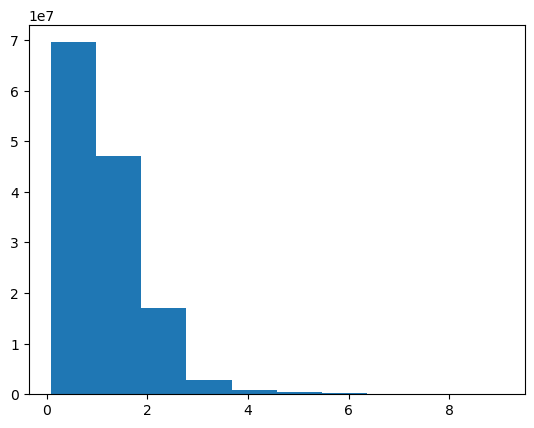

In [170]:
f = g[g>0].reshape((-1))
f=np.log(f+1)
plt.hist(f)

In [172]:
l=0
h=1
monomode = True
for i in range(7):
    thisbin = ((f<h)*(f>l)).sum()
    l+=1
    h+=1
    nextbin = ((f<h)*(f>l)).sum()
    if nextbin > thisbin:
        monomode = False
    print('thisbin:',thisbin,'nextbin:',nextbin)
        
print(monomode)

thisbin: 70463862 nextbin: 50466657
thisbin: 50466657 nextbin: 13985929
thisbin: 13985929 nextbin: 2141390
thisbin: 2141390 nextbin: 676283
thisbin: 676283 nextbin: 444973
thisbin: 444973 nextbin: 149723
thisbin: 149723 nextbin: 53297
True


In [173]:
(f>np.log1p(20)).sum()

3329323

In [174]:
(f>np.log1p(30)).sum()

2204453

In [175]:
(f>np.log1p(10)).sum()

8546954